In [16]:
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict,Counter
import json
from datasets import load_dataset
import pickle as pkl
from collections import defaultdict
import string

In [17]:
device="cuda:1"
model_name = "gemma-2-2b"
if "9b" in model_name:
    local_model_path = "/home/liubo/.cache/huggingface/hub/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6"
elif "2b" in model_name:
    local_model_path = "/home/liubo/.cache/huggingface/hub/models--google--gemma-2-2b/snapshots/c5ebcd40d208330abc697524c919956e692655cf"
elif 'gpt2' in model_name:
    local_model_path = '/home/liubo/.cache/huggingface/hub/models--openai-community--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e'
elif "bert-base" in model_name:
    local_model_path='/home/liubo/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594'
model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    torch_dtype=torch.float16,
    #attn_implementation="flash_attention_2",
    ).to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


## Tokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
tokenizer.pad_token = tokenizer.eos_token
#dataset_path = 'analyze_sae/sents_20.json'
#dataset_path = 'analyze_sae/data_500_samples.json'
dataset_path = 'analyze_sae/data_250_samples.json'

dataset_list = json.loads(open(dataset_path).read())

print(dataset_list)
print(dataset_list.keys())
total_tokens = 0
check_tokens = []
for sent in dataset_list:
    tokens = tokenizer.encode(dataset_list[sent], add_special_tokens=False)  # 加上 [CLS]/[SEP] 等特殊 token
    total_tokens += len(tokens)
    check_tokens.append(tokens)

print(f"token num: {total_tokens}")
print(check_tokens)


{'0': 'Tea brewed softly, filling the air with warmth. Kim poured herself a cup and opened a dusty book found in her attic. It spoke of a hidden world where trees were made of candy, and rivers flowed with chocolate. She smiled, remembering her childhood dreams of such a place.\n\nWith a spark of inspiration, she closed her eyes and imagined herself there. Suddenly, she was walking on a candy path, feeling the sweetness surround her. Each bite gave her strength, and she laughed with joy. Kim realized that her dreams were a treasure, giving her the power to escape reality whenever she needed.', '1': "Across the dark sea, a boat drifted with no one on board. Inside, there was a note left by a sailor who felt lost. It spoke of a place where people did not care for each other. As the tide pulled the boat closer to shore, a curious girl saw it.\n\nShe climbed aboard and read the note. The words made her sad, for she knew many people who were kind and caring. Inspired, she thought about how 

In [19]:
# 目标目录下所有sae_name
from dictionary_learning.trainers.top_k import AutoEncoderTopK
#sae = AutoEncoder(activation_dim=2, dict_size=2)
base_dir = os.getcwd()
layer = 4
# sae_dir = "gemma_hsic_output"
#sae_dir = "../SAEBench-main/Topk-new-test/100M"
sae_dir = "/home/liubo/workspace/SAEBench-main/sae_2b/fvu_hsic_full_hsic/topk_layer4"
#sae_dir = "../SAEBench-main/final_saes_dictionary_learning/500M/hsic/coff_100"
subdirs = [d for d in os.listdir(sae_dir) if os.path.isdir(os.path.join(sae_dir, d))]
for sae_name in subdirs:
    print(sae_name)

100fvu_cos_no_eyes-1024k-gemma-2-2b-resid_post_layer_4-5.0e+08-20251225_1333
100fvu_hsic-1024k-sample-gemma-2-2b-resid_post_layer_4-5.0e+08-20251223_1922
100fvu_cos_no_eyes-1024k-BatchTopK-gemma-2-2b-resid_post_layer_4-5.0e+08-20251228_1919
100fvu_hsic-1024k-BatchTopK-gemma-2-2b-resid_post_layer_4-5.0e+08-20251226_2325
fvu_only-1024k-BatchTopK-gemma-2-2b-resid_post_layer_4-5.0e+08-20251226_2325
100fvu_nce-1024k-gemma-2-2b-resid_post_layer_4-5.0e+08-20251225_1451
fvu_only-1024k-gemma-2-2b-resid_post_layer_4-5.0e+08-20251223_1922
10fvu_nce-1024k-BatchTopK-gemma-2-2b-resid_post_layer_4-5.0e+08-20251228_1919


In [24]:


#sae_name = "fvu_only_64k-gemma-2-2b-resid_post_layer_8-5.0e+08-20250809_1943"

sae_name = "100fvu_hsic-1024k-sample-gemma-2-2b-resid_post_layer_4-5.0e+08-20251223_1922"
#sae_name = "fvu_only-1024k-gemma-2-2b-resid_post_layer_4-5.0e+08-20251223_1922"
# 获取k值
with open(f"{sae_dir}/{sae_name}/resid_post_layer_{layer}/trainer_0/config.json",'r',encoding="utf8") as f:
    cfg = json.load(f)
k = cfg["trainer"]['k']
sae_type = cfg["trainer"]["dict_class"]
if "fvu_only" in sae_name:
    loss_type = "fvu_only"
elif "hsic" in sae_name:
    loss_type = "hsic"
else:
    loss_type=""    

print("k ",k)
ae_path = os.path.join(
    base_dir,
    sae_dir,
    sae_name,
    f"resid_post_layer_{layer}/trainer_0/ae.pt"
)
sae_name4label = sae_name.split('-')[0]

sae = AutoEncoderTopK.from_pretrained(ae_path,k, device=device)


k  1024


In [25]:
def batch_iter(dataset, batch_size=64):
    batch = []
    for idx in range(len(dataset)):
        batch.append((idx, dataset[str(idx)]))
        if len(batch) >= batch_size:
            yield batch
            batch=[]
    if batch:
        yield batch

def preproc(batch):
    sent_ids = []
    text_data = []
    for idx, text in batch:
        sent_ids.append(int(idx))
        text_data.append(text)
    
    input_data = tokenizer(
        text_data,
        padding="longest",  # 补齐到最长
        max_length=256,
        truncation=True,
        return_tensors="pt",
        )
    input_data["sent_ids"] = sent_ids
    return input_data

def is_valid_token(token_str):
    """
    返回 True 表示 token 是有效的（不是数字，不是标点，不是特殊 token）。
    """
    # 转小写方便匹配特殊 token
    token_lower = token_str.lower()

    tokens = {"<bos>", "<eos>", "<pad>", "<unk>"," "}
    if token_lower in tokens:
        return False
    
    # 排除纯数字
    if token_str.isdigit():
        return False
    
    # 排除标点符号
    if all(c in string.punctuation for c in token_str):
        return False
    
    return True

batch_size=32

In [26]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle as pkl

# 用于存储所有 token 样本的 latent 激活向量
all_token_vectors = [] 
# 用于存储每个 token 样本的唯一标识符
# 格式: [ (sent_id_1, index_j_1), (sent_id_2, index_j_2), ... ]
all_token_ids = []
global_token_count = 0 
token_nums={}

# 将每个有效 token 视为一个样本

for batch in tqdm(batch_iter(dataset_list, batch_size), total=len(dataset_list)//batch_size+1):
    input_data = preproc(batch)
    input_ids = input_data["input_ids"].to(device)

    sent_ids = input_data["sent_ids"] 
    mask = input_data["attention_mask"].to(device)
    
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=mask, output_hidden_states=True)
    
    hidden_states = output["hidden_states"][8] 
    batch_size, seq_len, hidden_dim = hidden_states.shape
    
    # 遍历 batch 中的每个样本（句子）
    for i in range(batch_size):
        current_sent_id = sent_ids[i]
        
        # 遍历序列中的每个 token
        for j in range(seq_len):
            token_id = input_ids[i, j].item()
            
            # 排除特殊 token (如 [CLS], [SEP], [PAD])
            if (not is_valid_token(tokenizer.decode(token_id))) :
                continue
            if token_id in token_nums:
                token_nums[token_id]+=1
            else:
                token_nums[token_id]=1
            token_emb = hidden_states[i, j].unsqueeze(0)
            
            with torch.no_grad():
                #获得 latent 激活向量 (latent_dim,)
                encoded = sae.encode(token_emb).squeeze(0)  
            
            all_token_vectors.append(encoded.cpu())
            

            token_str=tokenizer.decode(token_id)
            token_sample_id = f"{token_str}-{token_nums[token_id]}"#f"{current_sent_id}_{j}"
            all_token_ids.append(token_sample_id)
            
            global_token_count += 1



100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


In [27]:
import torch
import torch.nn.functional as F
import  pickle 
import pandas as pd
# 将所有 token 向量拼接成一个矩阵
# shape: [num_tokens, hidden_dim]
#print(type(all_token_vectors))
all_token_vectors = torch.stack(all_token_vectors)

# 归一化
all_token_vectors = F.normalize(all_token_vectors, p=2, dim=1)
# 余弦相似度矩阵
cos_sim_matrix = all_token_vectors @ all_token_vectors.T   # shape: [num_tokens, num_tokens]

N = cos_sim_matrix.size(0)
mean_off_diag = (cos_sim_matrix.sum() - N) / (N * (N - 1))
print("余弦相似度矩阵 shape:", cos_sim_matrix.shape)
print("去掉对角线后余弦相似度均值 ",mean_off_diag)

cos_sim_np = cos_sim_matrix.cpu().numpy()

df = pd.DataFrame(cos_sim_np, index=all_token_ids, columns=all_token_ids)

余弦相似度矩阵 shape: torch.Size([44109, 44109])
去掉对角线后余弦相似度均值  tensor(0.4075)


In [13]:
sample_num=250

In [14]:
df.to_parquet(f"analyze_sae/sample_cossim/{sae_name4label}_{layer}_cos_sim_{sample_num}samples.parquet")

print("已保存")


KeyboardInterrupt: 

In [24]:
df = pd.read_parquet(f"analyze_sae/sample_cossim/{sae_name4label}_cos_sim_{sample_num}samples.parquet")
print(df.head())

               Tea-1   brewed-1   softly-1   filling-1     the-1     air-1  \
Tea-1       1.000000   0.894917   0.847401    0.832677  0.787276  0.842308   
 brewed-1   0.894917   1.000000   0.888772    0.868377  0.832893  0.862500   
 softly-1   0.847401   0.888772   1.000000    0.872921  0.829865  0.870338   
 filling-1  0.832677   0.868377   0.872921    1.000000  0.913999  0.888928   
 the-1      0.787276   0.832893   0.829865    0.913999  1.000000  0.881322   

              with-1   warmth-1     Kim-1   poured-1  ...    a-1480     bar-2  \
Tea-1       0.777948   0.837000  0.868015   0.843313  ...  0.771697  0.835611   
 brewed-1   0.818153   0.863257  0.842527   0.890555  ...  0.784781  0.839448   
 softly-1   0.816119   0.881705  0.829187   0.859571  ...  0.771535  0.807141   
 filling-1  0.866198   0.863779  0.828475   0.879113  ...  0.793685  0.801294   
 the-1      0.873625   0.821704  0.779047   0.829127  ...  0.818559  0.763755   

              it-393   was-582    a-1481    

In [30]:
# 两个余弦相似度csv文件路径
# file1="analyze_sae/sample_cossim/fvu_only_cos_sim.csv"
# file2="analyze_sae/sample_cossim/100fvu_hsic_cos_sim.csv"
file1 = "analyze_sae/sample_cossim/fvu_only_cos_sim_250samples.parquet"
file2 = "analyze_sae/sample_cossim/100fvu_hsic_cos_sim_250samples.parquet"


In [35]:
# 
import pandas as pd
# matrix1 = pd.read_csv(file1, index_col=0)
# matrix2 = pd.read_csv(file2, index_col=0)
matrix1 = pd.read_parquet(file1)
matrix2 = pd.read_parquet(file2)
print("average cos sim")
print(np.mean(matrix1),np.mean(matrix2))
print(matrix1.shape)
print(matrix2.shape)

average cos sim
0.80952114 0.263249
(44109, 44109)
(44109, 44109)


In [ ]:
# 差值矩阵
diff_matrix = matrix1 - matrix2

不重复的前 20 个最大差值：
( brewed-1,  drought-2) -> 差值 = 0.7381
( breathe-1, Lur-1) -> 差值 = 0.7372
( stars-3, Castle-1) -> 差值 = 0.7345
( brewed-1,  rainbow-10) -> 差值 = 0.7345
( brewed-1,  rain-26) -> 差值 = 0.7344
( Lightning-1, Joy-1) -> 差值 = 0.7341
( Lightning-1, Joy-2) -> 差值 = 0.7339
( rain-1,  fetch-1) -> 差值 = 0.7337
( Eve-1,  fetch-1) -> 差值 = 0.7336
( rain-8,  fetch-1) -> 差值 = 0.7333
( dawn-4, Loud-1) -> 差值 = 0.7331
( bird-8, Lur-1) -> 差值 = 0.7316
( brewed-1,  scarf-3) -> 差值 = 0.7314
( dive-1, Lur-1) -> 差值 = 0.7314
( brewed-1,  applause-1) -> 差值 = 0.7313
( brewed-1,  rain-28) -> 差值 = 0.7311
( chir-3, Thought-1) -> 差值 = 0.7306
( rain-6,  fetch-1) -> 差值 = 0.7305
( pencil-1,  sky-46) -> 差值 = 0.7303
( chir-4, Thought-1) -> 差值 = 0.7302


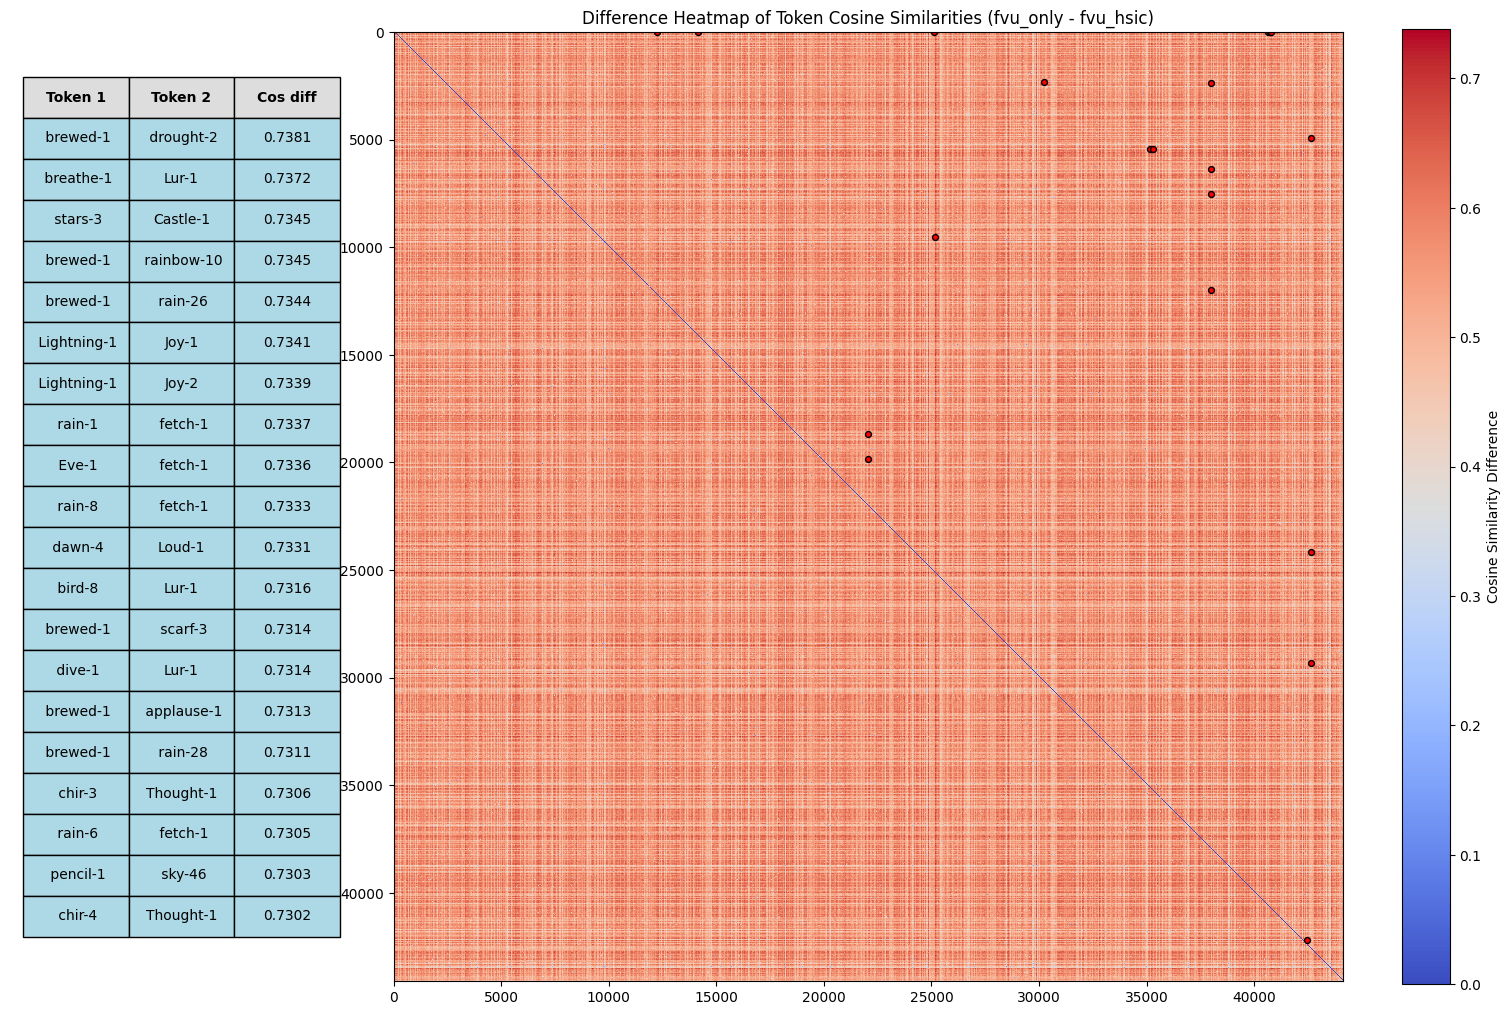

In [34]:
import numpy as np
import matplotlib.pyplot as plt

abs_diff = diff_matrix.abs()

abs_diff_np = abs_diff.values
diff_np = diff_matrix.values
n = abs_diff_np.shape[0]

# 上三角掩码
triu_indices = np.triu_indices(n, k=1)

values = abs_diff_np[triu_indices]
sorted_idx = np.argsort(values)[::-1]  # 从大到小排序

topk = 20
top_pairs = [(triu_indices[0][idx], triu_indices[1][idx]) for idx in sorted_idx[:topk]]

print(f"不重复的前 {topk} 个最大差值：")
for (i, j) in top_pairs:
    token_i = abs_diff.index[i]
    token_j = abs_diff.columns[j]
    val = diff_np[i, j]
    print(f"({token_i}, {token_j}) -> 差值 = {val:.4f}")

# 创建图形和子图布局
fig = plt.figure(figsize=(16, 10))
# 使用GridSpec创建复杂的子图布局
gs = plt.GridSpec(1, 2, width_ratios=[1, 4.5])  # 左侧文本区域:右侧热力图区域 = 1:4

# 左侧文本区域
ax_text = fig.add_subplot(gs[0])
ax_text.axis('off')  # 不显示坐标轴

# 准备表格数据
table_data = []
for (i, j) in top_pairs:
    token_i = abs_diff.index[i]
    token_j = abs_diff.columns[j]
    val = diff_np[i, j]
    table_data.append([token_i, token_j, f"{val:.4f}"])

# 创建表格
table = ax_text.table(
    cellText=table_data,
    loc='center',
    cellLoc='center',  # 居中
    colLabels=['Token 1', 'Token 2', 'Cos diff'],  # 列标题
    bbox=[0.05, 0.05, 1.2, 0.9]  # [left, bottom, width, height]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)  # 行高

# 列标题
for i in range(3):
    table[(0, i)].set_facecolor('#DDDDDD')
    table[(0, i)].set_text_props(weight='bold')

# 单元格样式
for i in range(len(table_data)):
    for j in range(3):
        table[(i+1, j)].set_facecolor('lightblue')

# 右侧热力图区域
ax_heatmap = fig.add_subplot(gs[1])
# 绘制热力图
im = ax_heatmap.imshow(diff_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im, ax=ax_heatmap, label="Cosine Similarity Difference")
ax_heatmap.set_title("Difference Heatmap of Token Cosine Similarities (fvu_only - fvu_hsic)")

# 标出前后差值最大的topk点
for (i, j) in top_pairs:
    ax_heatmap.scatter(j, i, color='red', s=18, edgecolors='black')

plt.tight_layout()
plt.savefig(f"analyze_sae/sample_cossim/cos_sim_dff_top{topk}.png",dpi=300)
plt.savefig(f"analyze_sae/sample_cossim/cos_sim_dff_top{topk}.pdf",dpi=300)
plt.show()
